In [6]:
# This cell can take some minutes to run
# You should only need to run this cell once and not everytime you open the script
# In case the plotting of the data below does not work because of the error "Error displaying widget: model not found"
# First, try only running "Run" << "Factory Reset"
# If this does not help, run this cell again and then "Run" << "Factory Reset"

# IMPORTANT: After running this cell, go to the top of the page and select "Run" << "Factory Reset"
!jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet
!pip install install nodejs

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
An error occurred.
ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
See the log file for details:  /var/folders/zf/6vgqjplx04s3k3bdvj13s5bc0000gn/T/jupyterlab-debug-7g08akg_.log


In [7]:
import matplotlib.pyplot as plt

# You may make changes to the Lilygo module but your algorithm must work with the original version
# If you want to propose changes to the module, create a pull-request on github
from Lilygo.Recording import Recording, data_integrity
from Lilygo.Dataset import Dataset

# For interactive graphs
%matplotlib widget

# Reading sensor data from JSON file

Create an instance of the <code>Recording</code> class that manages the data from a file

In [23]:
trace = Recording('./data/recorded/L0/4/lilygo_25_04_16_42_52.json', no_labels=False, mute=True)  # Second example file: data/example/short_walk.json

trace.DataIntegrityCheck()

# The data is stored inside a dictionary (access: trace.data["key"])
print("\r\nAvailable data traces:")
print(list(trace.data.keys()))

if not(trace.labels is None):
    print("\r\nLabels: ")
    print(trace.labels)

New data file without labels, please provide labels, if you want to later upload it for submission or label it for internal use!
Note: Please deactivate this function by setting no_labels=True in your algorithm submission


Where was the board worn? (0 - wrist left, 1 - belt, 2 - right ankle), provide either an integer (e.g. '0') or a string (e.g.'wrist left'), n: cancel


What path was this trace recorded on? Provide integer in [0, 4] corresponding to the path index in the task set (e.g. '0'), n: cancel


What activities are included in the trace (min. 1 min, See task set for specifications)?
0: standing still, 1: walk, 2: run, 3: cycle
Provide integer comma separated list of integers or strings, avoid duplicates (input e.g., '0, 2' or 'standing still, run'), n: cancel


What is the birth sex of the person who recorded the data?
f - female, m - male, s - prefer not to respond
(This data is acquired to improve the data set quality for possible further analysis)


What is the body heigh

## Working with timeseries
Every value in this dictionary holds a <code>Dataset</code> object to manage the data from one sensor

# Plotting

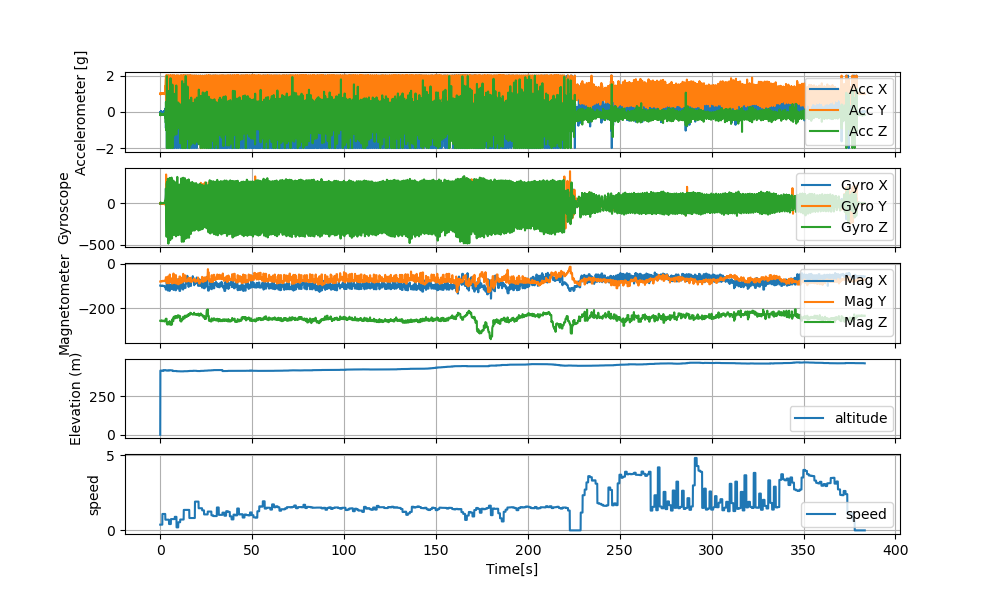

In [21]:
# Plot multiple sensors and multiple axis at the same time
trace.plot([['ax', 'ay', 'az'], ['gx', 'gy', 'gz'], ['mx', 'my', 'mz'], ['altitude'], ['speed']], 
             ylabels=['Accelerometer [g]', 'Gyroscope', 'Magnetometer', 'Elevation (m)', 'speed'],
             labels=[['Acc X', 'Acc Y', 'Acc Z'], ['Gyro X', 'Gyro Y', 'Gyro Z'], ['Mag X', 'Mag Y', 'Mag Z'], ['altitude'], ['speed']])

# Display GPS data

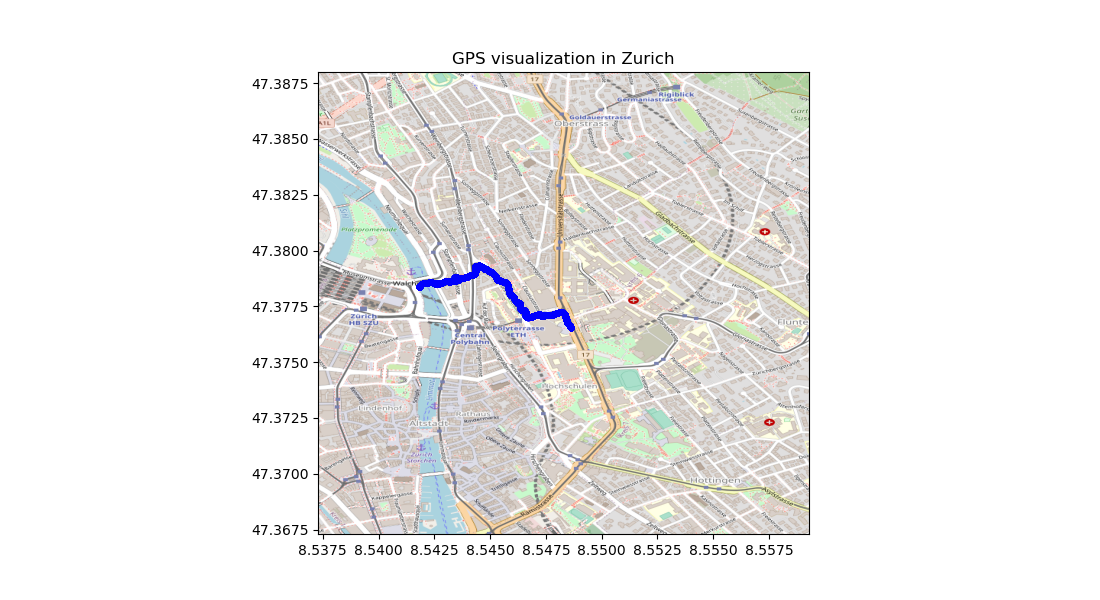

In [21]:
# Trace must contain gps data
assert('latitude' in trace.data and 'longitude' in trace.data)

plot_map_zurich = True

# Visualize the path of the trace
fig, ax = plt.subplots(figsize = (11,6))
ax.scatter(trace.data['longitude'].values, trace.data['latitude'].values, zorder=1, alpha= 0.9, c='b', s=10)
ax.set_title('Visualization of the path')

if plot_map_zurich:
    # Bounding coordinates for map
    BBox = (8.5373,8.5593,
            47.3673, 47.3880)
    # Load map of Zurich
    ruh_m = plt.imread('mapzurich.png')
    ax.set_title('GPS visualization in Zurich')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(ruh_m, zorder=0, extent = BBox)

# Generate computed traces

Small example that adds an accelerometer magnitude trace

<code>Dataset.fromLists(name, values, timestamps)</code> can be used to save a new or modified sensor into the Recording object.

<code>name</code>: used for plotting  
<code>values</code>: modified values  
<code>timestamps</code>: list of timestamps, one timestamp per value, usually directly taken from the original data

Note: This change is only executed locally and not saved to the json file. Everytime you reload your dataset, you have to re-execute this calculation


In [ ]:
from math import sqrt

# Trace must contain lilygo accelerometer data
assert('ax' in trace.data and 'ay' in trace.data and 'az' in trace.data)
# And those traces must be of the same length
assert(len(trace.data['ax'].values) == len(trace.data['ay'].values)  and len(trace.data['ax'].values) == len(trace.data['az'].values) )

magn = [sqrt(a**2+trace.data['ay'].values[i]**2+trace.data['az'].values[i]**2)for i, a in enumerate(trace.data['ax'].values)]

trace.data['amagn'] = Dataset.fromLists('Accelerometer magnitude', magn, trace.data['ax'].timestamps)

trace.plot([['ax', 'ay', 'az'], ['amagn']])

# FYI: How timestamps are handeled (you probably don't need this)

Every time the app receives a bluetooth package, up to 16 sensor values are stored at once together with the current timestamp. So not every sensor reading has a 100% perfectly defined timestamp.

Every <code>Dataset</code> has a list of <code>raw_timestamps</code> which are tuples of type <code>(packet number, timestamp)</code>

The timestamps are standard unix timestamps in milliseconds

For example the first two entries say "The 0th value came in at 1641564932653, the 16th value at 1641564932694"

In [ ]:
trace.data['ax'].raw_timestamps[-1][1]-trace.data['ax'].raw_timestamps[0][1]

The LILYGO uses a FIFO with a constant sample rate, so it should be a fair assumption, that the delay between two consecutive reaings always is the same.

By default the <code>Dataset.timestamps</code> list is linearly interpolated between the first and the last timestamps (<code>linspace(0, last_timestamp, num=len(values))</code>)

In [ ]:
# Compare "ideal" interpolated timestamps against actual received timestamps
trace.data['ideal_ts'] = Dataset('ideal_ts', 
                                   [trace.data['timestamp'].values[0],trace.data['timestamp'].values[-1]], 
                                   [(0,trace.data['timestamp'].values[0]), 
                                    (len(trace.data['timestamp'].values), trace.data['timestamp'].values[-1])])
trace.plot(['timestamp', 'ideal_ts'], labels=['Received timestamps', 'Calculated Timestamps'], ylabels=['ms'])